In [20]:
import pandas as pd
from neo4j import GraphDatabase
from tqdm import tqdm
import json
import random
import plotly.express as px
import os
import sys

import plot

eval_dir = os.path.join(os.path.realpath('../..'), 'akbc_2021/eval')
sys.path.append(eval_dir) 
import utils as ut

In [2]:
# setup database connection
driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'fb14'))
sess = driver.session()

# data dir
data_dir = '../../data/'

rels = ['parents']

# if this is not None, will restrict the number of triples to include in the benchmark
n_test = None

write_to_file = True
outversion = 'v5'

random.seed(42)

In [3]:
outdir = f'{data_dir}/commonsense_benchmark/{outversion}/'
if write_to_file and not os.path.isdir(outdir):
    print(f'Creating output directory {outdir}')
    os.makedirs(outdir)

In [4]:
scores = {'high': 1,
          'medium': 0.5,
          'low': 0.25}

In [5]:
def get_path_config_for_query_triple(row):
    head = row['head']
    tail = row['tail']
    if row.rel == 'parents':
        labels = ['Person', 'Person']
        path_config = [
            {'metapath': [tail, 'children', head],
             'labels': labels,
             'confidence': scores['high'],
             'category': 'parent--child',
             'category_abcd': 'A--C'
            },            
            {'metapath': [tail, 'spouse', None, 'children', head],
             'labels': labels, 
             'confidence': scores['medium'],
             'category': 'parent--coparent--child',
             'category_abcd': 'A--B--C',
             'first_hop_config': {
                 'category': 'parent--coparent',
                 'category_abcd': 'A--B',
                 'confidence': scores['medium']
             }
            },
            {'metapath': [head, 'parents', None, 'spouse', tail],
             'labels': labels, 
             'confidence': scores['medium'],
             'category': 'parent--coparent--child',
             'category_abcd': 'A--B--C',
             'first_hop_config': {
                 'category': 'coparent--child',
                 'category_abcd': 'B--C',
                 'confidence': scores['medium']
             }
            },
            {'metapath': [head, 'sibling', None, 'parents', tail],
             'labels': labels,
             'confidence': scores['high'], 
             'category': 'parent--sibling--child',
             'category_abcd': 'A--D--C',
             'first_hop_config': {
                 'category': 'child--sibling',
                 'category_abcd': 'D--C',
                 'confidence': scores['high']
             }
            },
            {'metapath': [tail, 'children', None, 'sibling', head],
             'labels': labels,
             'confidence': scores['high'], 
             'category': 'parent--sibling--child',
             'category_abcd': 'A--D--C',
             'first_hop_config': {
                 'category': 'parent--sibling',
                 'category_abcd': 'A--D',
                 'confidence': scores['high']
             }
            }
        ]
            
    elif row.rel == 'location':
        labels = ['Person', 'Location']
        path_config = [
            {'metapath': [head, 'nationality', tail],
             'labels': labels,
             'confidence': scores['medium'],
             'category': 'person--nationality'
            },
            {'metapath': [head, 'place_of_birth', tail],
             'labels': labels,
             'confidence': scores['medium'],
             'category': 'person--placeofbirth'
            },
            {'metapath': [head, 'place_of_death', tail],
             'labels': labels,
             'confidence': scores['medium'],
             'category': 'person--placeofdeath'
            },
            {'metapath': [head, 'parents', None, 'location', tail],
             'labels': labels,
             'confidence': scores['low'],
             'category': 'person--parent--location',
             'first_hop_config': {
                 'category': 'person--parent',
                 'confidence': scores['low']
             }
            },
            {'metapath': [head, 'children', None, 'location', tail], 
             'labels': labels, 
             'confidence': scores['low'],
             'category': 'person--child--location',
             'first_hop_config': {
                 'category': 'person--child',
                 'confidence': scores['low']
             }
            },
            {'metapath': [head, 'spouse', None, 'location', tail],
             'labels': labels,
             'confidence': scores['medium'],
             'category': 'person--spouse--location',
             'first_hop_config': {
                 'category': 'person--spouse',
                 'confidence': scores['low']
             }
            },
            {'metapath': [head, 'sibling', None, 'location', tail],
             'labels': labels,
             'confidence': scores['medium'],
             'category': 'person--sibling--location',
             'first_hop_config': {
                 'category': 'person--sibling',
                 'confidence': scores['low']
             }
            }
        ]
    elif row.rel == 'nationality':
        labels = ['Person', 'Location']
        path_config = [
            {'metapath': [head, 'location', tail],
             'labels': labels,
             'confidence': scores['low'],
             'category': 'person--location'
            },
            {'metapath': [head, 'place_of_birth', tail],
             'labels': labels,
             'confidence': 3,
             'category': 'person--placeofbirth'
            },
            {'metapath': [head, 'place_of_death', tail],
             'labels': labels,
             'confidence': scores['medium'],
             'category': 'person--placeofdeath'
            },
            {'metapath': [head, 'parents', None, 'place_of_birth', tail],
             'labels': labels,
             'confidence': scores['low'],
             'category': 'person--parent--place_of_birth',
             'first_hop_config': {
                 'category': 'person--parent',
                 'confidence': scores['low']
             },
             'second_hop_config': {
                 'category': 'parent--place_of_birth',
                 'confidence': scores['low']
             }
            },
            {'metapath': [head, 'children', None, 'place_of_birth', tail], 
             'labels': labels, 
             'confidence': scores['low'],
             'category': 'person--child--place_of_birth',
             'first_hop_config': {
                 'category': 'person--child',
                 'confidence': scores['low']
             },
             'second_hop_config': {
                 'category': 'child--place_of_birth',
                 'confidence': scores['low']
             }
            },
            {'metapath': [head, 'spouse', None, 'place_of_birth', tail],
             'labels': labels,
             'confidence': scores['low'],
             'category': 'person--spouse--place_of_birth',
             'first_hop_config': {
                 'category': 'person--spouse',
                 'confidence': scores['low']
             },
             'second_hop_config': {
                 'category': 'spouse--place_of_birth',
                 'confidence': scores['low']
             }
            },
            {'metapath': [head, 'sibling', None, 'place_of_birth', tail],
             'labels': labels,
             'confidence': scores['low'],
             'category': 'person--sibling--place_of_birth',
             'first_hop_config': {
                 'category': 'person--sibling',
                 'confidence': scores['low']
             },
             'second_hop_config': {
                 'category': 'sibling--place_of_birth',
                 'confidence': scores['low']
             }
            },
            {'metapath': [head, 'parents', None, 'place_of_death', tail],
             'labels': labels,
             'confidence': scores['low'],
             'category': 'person--parent--place_of_death',
             'first_hop_config': {
                 'category': 'person--parent',
                 'confidence': scores['low']
             },
             'second_hop_config': {
                 'category': 'parent--place_of_death',
                 'confidence': scores['low']
             }
            },
            {'metapath': [head, 'parents', None, 'nationality', tail],
             'labels': labels,
             'confidence': scores['medium'],
             'category': 'person--parent--nationality',
             'first_hop_config': {
                 'category': 'person--parent',
                 'confidence': scores['low']
             },
             'second_hop_config': {
                 'category': 'parent--nationality',
                 'confidence': scores['medium']
             }
            },
            {'metapath': [head, 'children', None, 'nationality', tail], 
             'labels': labels, 
             'confidence': scores['medium'],
             'category': 'person--child--nationality',
             'first_hop_config': {
                 'category': 'person--child',
                 'confidence': scores['low']
             },
             'second_hop_config': {
                 'category': 'child--nationality',
                 'confidence': scores['medium']
             }
            },
            {'metapath': [head, 'spouse', None, 'nationality', tail],
             'labels': labels,
             'confidence': scores['medium'],
             'category': 'person--spouse--nationality',
             'first_hop_config': {
                 'category': 'person--spouse',
                 'confidence': scores['low']
             },
             'second_hop_config': {
                 'category': 'spouse--nationality',
                 'confidence': scores['medium']
             }
            },
            {'metapath': [head, 'sibling', None, 'nationality', tail],
             'labels': labels,
             'confidence': scores['medium'],
             'category': 'person--sibling--nationality',
             'first_hop_config': {
                 'category': 'person--sibling',
                 'confidence': scores['low']
             },
             'second_hop_config': {
                 'category': 'sibling--nationality',
                 'confidence': scores['medium']
             }
            }
        ]
    else:
        raise ValueError('Unexpected value in row.rel, should be in ["parents", "location", "nationality"]')
    
    return path_config

In [6]:
def find_explanations_via_metapath(path_info, sess=sess, verbose=False):
    metapath = path_info['metapath']
    labels = path_info['labels']
    
    if len(metapath) == 3:
        q = construct_one_hop_query(metapath=metapath, labels=labels, sess=sess, verbose=verbose)
    elif len(metapath) == 5:
        q = construct_two_hop_query(metapath=metapath, labels=labels, sess=sess, verbose=verbose)
    else:
        raise ValueError('Length of metapath should be 3 or 5')
    
    if verbose: print(q)
    
    results = ut.res_to_df(sess.run(q))
    
    return construct_explanations_from_results_df(results, path_info)

def construct_one_hop_query(metapath, labels, sess, verbose=False):

    assert len(metapath) == 3
    
    node1 = node_name_to_cypher_str(node_name=metapath[0], var_name='u', label=labels[0])
    node2 = node_name_to_cypher_str(node_name=metapath[2], var_name='v', label=labels[1])
    rel = metapath[1]
    
    q = f'''
    MATCH {node1}-[r:{rel}]->{node2}
    RETURN u.name as PATH_u, type(r) as PATH_rel, v.name as PATH_v, r.split as SPLIT_rel
    '''
    
    return q

def construct_two_hop_query(metapath, labels, sess, verbose=False):
    
    assert len(metapath) == 5
    assert metapath[2] is None
    
    node1 = node_name_to_cypher_str(node_name=metapath[0], var_name='u', label=labels[0])
    node2 = node_name_to_cypher_str(node_name=metapath[4], var_name='v', label=labels[1]) 
    
    rel1 = metapath[1]
    rel2 = metapath[3]
    
    q = f'''
    MATCH {node1}-[r1:{rel1}]->(x)-[r2:{rel2}]->{node2}
    RETURN u.name as PATH_u, type(r1) as PATH_rel1, x.name as PATH_x, type(r2) as PATH_rel2, v.name as PATH_v,
    r1.split as SPLIT_rel1, r2.split as SPLIT_rel2
    '''
    
    return q

def construct_explanations_from_results_df(results, path_info):    
    if results.shape[0] == 0:
        explanations = []
    else:
        rdict = results.to_dict(orient='index')
        explanations = [construct_explanation_from_results_row(row, path_info) for row in rdict.values()]
        
        if 'first_hop_config' in path_info.keys():
            config = path_info['first_hop_config']
            explanations_hop1 = [construct_explanation_from_results_row(row, config, hops='first') for row in rdict.values()]
            explanations.extend(explanations_hop1)
            
        if 'second_hop_config' in path_info.keys():
            config = path_info['second_hop_config']
            explanations_hop2 = [construct_explanation_from_results_row(row, config, hops='second') for row in rdict.values()]
            explanations.extend(explanations_hop2)
            
    return explanations

def construct_explanation_from_results_row(row, config, hops='all'):
    
    path = [value for key, value in row.items() if key.startswith('PATH_')]
    splits = [value for key, value in row.items() if key.startswith('SPLIT_')]
    
    if hops == 'first':
        path = path[:3]
        splits = splits[0]
    elif hops == 'second':
        path = path[2:]
        splits = splits[1]
    else:
        assert hops == 'all'
    
    explanation = {
        'path': path,
        'category': config['category'],
        'confidence': config['confidence'],
        'splits': splits
    }
    
    if 'category_abcd' in config.keys():
        explanation['category_abcd'] = config['category_abcd']
    
    return explanation

def node_name_to_cypher_str(node_name, var_name, label):
    return f"({var_name}:{label} {{name: '{node_name}'}})" 

In [7]:
def extract_explanations_for_query_triples(triples, sess):
    out = list()
    for i, row in tqdm(triples.iterrows(), total=triples.shape[0]):
    
        B = dict()

        B['query_triple'] = [row['head'], row['rel'], row['tail']]
        B['category'] = row.rel
        B['split'] = row.split
        B['explanatory_paths'] = []

        path_config = get_path_config_for_query_triple(row)

        for path_info in path_config:
            explanations = find_explanations_via_metapath(path_info=path_info, sess=sess, verbose=False)
            B['explanatory_paths'].extend(explanations)
        
        if row.rel == 'parents':        
            B['entity_names'] = {
            'child': get_child_from_parents_bmk(B),
            'parent': get_parent_from_parents_bmk(B),
            'coparent': get_coparent_from_parents_bmk(B),
            'siblings': get_siblings_from_parents_bmk(B)
            }
#         elif rel == 'nationality':
#             B['entity_names'] = {
#                 'children':,
#                 'parents':,
#                 'siblings':,
#                 'spouses':,
#                 'nationality':
#             }
        else:
            print('Warning: not adding entity names')

        out.append(B)
    return out

def select_examples_from_bmk(BMK, n, rel, split, idx_out_of_bounds, min_explanatory_paths=None):
    idx = []
    for i, b in enumerate(BMK):
        if (b['category'] == rel) and (b['split'] == split) and (i not in idx_out_of_bounds):
            if min_explanatory_paths is None or len(b['explanatory_paths']) >= min_explanatory_paths:
                idx.append(i)
    samples = random.sample(idx, n)
    return samples

def get_coparent_from_parents_bmk(bmk):
    coparent = None
    for p in bmk['explanatory_paths']:
        if p['category'] in ['coparent--child', 'parent--coparent']:
            coparent = p['path'][2]
            break
    return coparent

def get_siblings_from_parents_bmk(bmk):
    siblings = set()
    for p in bmk['explanatory_paths']:
        if p['category'] in ['child--sibling', 'parent--sibling']:
            siblings.add(p['path'][2])
    return list(siblings)

def get_parent_from_parents_bmk(bmk):
    triple = bmk['query_triple']
    assert triple[1] == 'parents'
    return triple[2]

def get_child_from_parents_bmk(bmk):
    triple = bmk['query_triple']
    assert triple[1] == 'parents'
    return triple[0]

In [8]:
def read_triples(file, **addl_cols):
    triples = pd.read_csv(file, sep='\t', names=['head', 'rel', 'tail'])
    for key, value in addl_cols.items():
        triples[key] = value
    return triples

def get_node_degree(sess):
    q = f'MATCH (n)-[r]-(x) RETURN n.name as name, count(distinct x) as neighbors ORDER BY neighbors DESC'
    return ut.res_to_df(sess.run(q))

In [9]:
# Read in all triples
splits = ['train', 'valid', 'test']
base_dir = f'{data_dir}/fb13/resplit_with_sibs'
g_list = [read_triples(f'{base_dir}/{split}.txt', split=split) for split in splits]
graph = pd.concat(g_list, axis=0)

# Pull out selected relations and shuffle
triples = graph[graph.rel.isin(rels)]
triples = triples.sample(frac=1)
triples.reset_index(inplace=True, drop=True)

In [10]:
if n_test is not None:
    triples = triples.iloc[:n_test,]

In [11]:
BMK = extract_explanations_for_query_triples(triples, sess)
BMK = [b for b in BMK if len(b['explanatory_paths']) > 0]

100%|██████████| 6260/6260 [28:40<00:00,  3.64it/s]


### Plot histogram

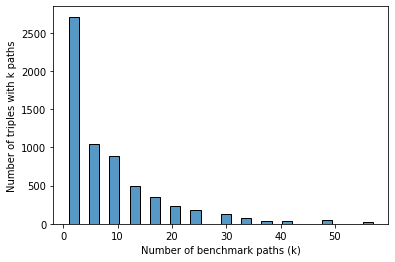

In [21]:
rows = []
for i, p in enumerate(BMK):
    rows.append({
        'num_paths': len(p['explanatory_paths']),
        'category': p['category']
    })
num_paths = pd.DataFrame(rows)

import seaborn as sns
g = sns.histplot(data=num_paths, x='num_paths', bins=30)
_ = g.set(ylabel='Number of triples with k paths', xlabel='Number of benchmark paths (k)')
figure_dir = '/Users/rhodos/Desktop/Projects/akbc2021/figures/submission_june_21/'
_ = g.get_figure().savefig(f'{figure_dir}benchmark_histogram.{plot.figtype}', bbox_inches='tight')

### Filter to a single sibling and write to file

In [22]:
# filter to triples with one sibling
BMK_filtered = [bmk for bmk in BMK if len(bmk['entity_names']['siblings']) == 1]
print(f'Filtered to {len(BMK_filtered)} triples with exactly 1 sibling')

Filtered to 895 triples with exactly 1 sibling


In [23]:
if write_to_file:
    with open(f'{outdir}/commonsense_benchmark_one_sibling.json', 'w') as f:
         json.dump(BMK_filtered, f, indent=4)
    with open(f'{outdir}/commonsense_benchmark_all.json', 'w') as f:
         json.dump(BMK, f, indent=4)       
else:
    print('not writing to file')